In [1]:
pip install -q torchdiffeq

Note: you may need to restart the kernel to use updated packages.


Starting training...
Epoch 0, Loss: 1.4864
Epoch 500, Loss: 0.9651
Epoch 1000, Loss: 1.0421
Epoch 1500, Loss: 1.1010
Epoch 2000, Loss: 0.9641
Epoch 2500, Loss: 1.0663
Epoch 3000, Loss: 0.9314
Epoch 3500, Loss: 0.9409
Epoch 4000, Loss: 1.0536
Epoch 4500, Loss: 0.9264
Training finished.


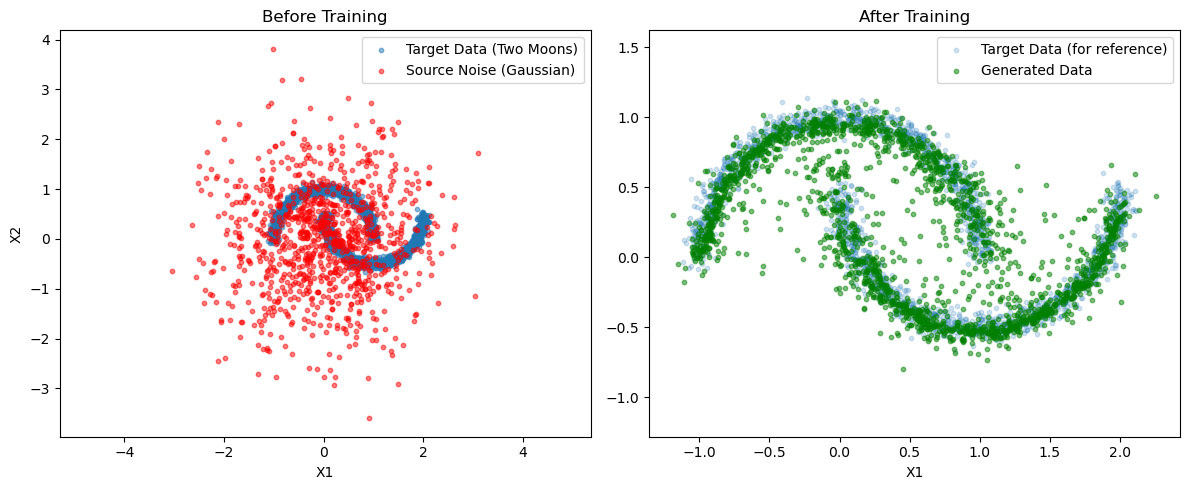

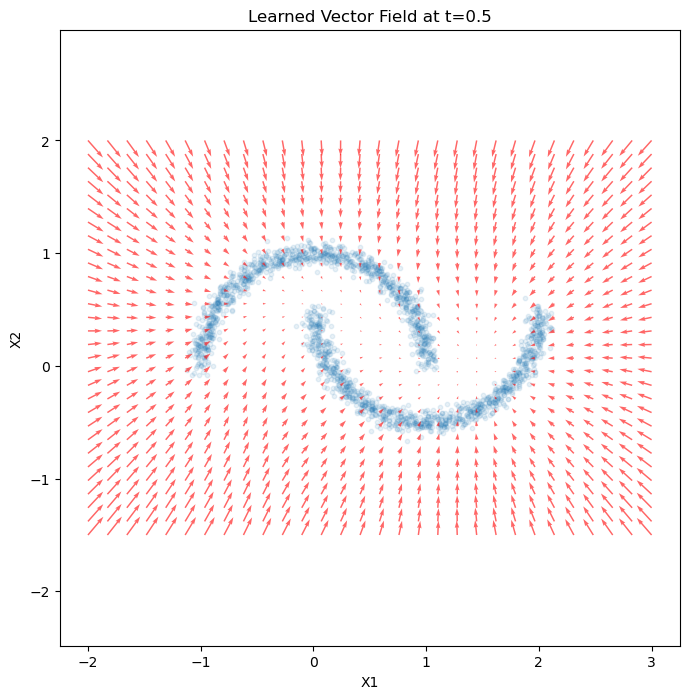

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torchdiffeq import odeint
import numpy as np

# --- 1. Setup and Data ---
# Use a simple 2D dataset to visualize the process easily.
# The "two moons" dataset is a classic choice for generative models.
X, _ = make_moons(n_samples=2000, noise=0.05)
target_data = torch.tensor(X, dtype=torch.float32)

# --- 2. The Neural Network (Vector Field) ---
# This network will learn the vector field v(x, t).
# It takes a point 'x' (2 dims) and a time 't' (1 dim) as input,
# and outputs a vector (2 dims).
class VectorField(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        # The network needs to process both the data dimension and the time dimension.
        self.network = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        # We need to reshape t to concatenate it with x.
        # t is a scalar, so we expand it to the same batch size as x.
        t_vec = t.expand(x.size(0), 1)
        # Concatenate the spatial and time dimensions.
        xt = torch.cat([x, t_vec], dim=1)
        return self.network(xt)

# --- 3. The Flow Matching Loss ---
# This function implements the loss from Step 3 of our discussion.
def flow_matching_loss(model, x1, x0=None):
    """
    Calculates the Flow Matching loss.
    Args:
        model: The neural network that models the vector field.
        x1: A batch of real data samples (the target).
        x0: A batch of noise samples (the source). If None, will be sampled internally.
    """
    # Sample the source distribution (standard Gaussian noise)
    if x0 is None:
        x0 = torch.randn_like(x1)

    # Sample a random time t from Uniform(0, 1)
    t = torch.rand(x1.size(0), 1)

    # Calculate the point on the path xt using linear interpolation (Step 1)
    xt = (1 - t) * x0 + t * x1

    # Define the true velocity vector (the "instruction" from Step 2)
    ut = x1 - x0

    # Get the model's predicted velocity at xt and t
    vt = model(xt, t)

    # Calculate the mean squared error between the predicted and true velocities
    loss = torch.mean((vt - ut)**2)
    return loss

# --- 4. The Training Loop ---
def train_model(data, model, epochs=5000, batch_size=256, lr=1e-3):
    """
    Trains the VectorField model.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print("Starting training...")
    for epoch in range(epochs):
        optimizer.zero_grad()

        # Get a random batch of data from the target distribution
        indices = torch.randint(0, len(data), (batch_size,))
        x1_batch = data[indices]

        # Calculate the loss
        loss = flow_matching_loss(model, x1_batch)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    print("Training finished.")

# --- 5. Generation (Inference) ---
# This function uses the trained model to generate new samples (Step 4).
def generate_samples(model, num_samples=1000):
    """
    Generates new samples by solving the ODE from t=0 to t=1.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # 1. Start with random noise (the source)
        x0 = torch.randn(num_samples, 2)

        # 2. Define the ODE function for the solver.
        # The solver needs a function that takes (t, x) and returns dx/dt.
        # Our model v(x, t) is exactly that function.
        def ode_func(t, x):
            # The ODE solver passes t as a float, so we need to convert it
            # to a tensor of the correct shape for our model.
            t_tensor = torch.full((x.size(0), 1), t.item())
            return model(x, t_tensor)

        # 3. Define the time span for the integration
        t_span = torch.tensor([0.0, 1.0])

        # 4. Solve the ODE.
        # 'odeint' integrates the 'ode_func' from t=0 to t=1, starting from x0.
        # The result will be a tensor of shape (time_points, batch_size, dims).
        # We only care about the final point at t=1.
        generated_x = odeint(ode_func, x0, t_span)[-1]

    return generated_x.cpu().numpy()


# --- Main Execution ---
if __name__ == '__main__':
    # Instantiate the model
    flow_model = VectorField()

    # --- Visualize the initial state ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(target_data[:, 0], target_data[:, 1], s=10, alpha=0.5, label='Target Data (Two Moons)')
    noise = torch.randn(1000, 2)
    plt.scatter(noise[:, 0], noise[:, 1], s=10, alpha=0.5, c='r', label='Source Noise (Gaussian)')
    plt.title('Before Training')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.axis('equal')


    # Train the model
    train_model(target_data, flow_model)

    # Generate new samples using the trained model
    generated_data = generate_samples(flow_model, num_samples=2000)

    # --- Visualize the final result ---
    plt.subplot(1, 2, 2)
    plt.scatter(target_data[:, 0], target_data[:, 1], s=10, alpha=0.2, label='Target Data (for reference)')
    plt.scatter(generated_data[:, 0], generated_data[:, 1], s=10, alpha=0.5, c='g', label='Generated Data')
    plt.title('After Training')
    plt.xlabel('X1')
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    # --- Visualize the learned vector field (optional) ---
    # Create a grid of points
    x = np.linspace(-2, 3, 30)
    y = np.linspace(-1.5, 2, 30)
    X_grid, Y_grid = np.meshgrid(x, y)
    points = torch.tensor(np.vstack([X_grid.ravel(), Y_grid.ravel()]).T, dtype=torch.float32)

    # Get the vector field at t=0.5
    with torch.no_grad():
        t_mid = torch.tensor(0.5)
        vectors = flow_model(points, t_mid).cpu().numpy()

    plt.figure(figsize=(8, 8))
    plt.scatter(target_data[:, 0], target_data[:, 1], s=10, alpha=0.1)
    plt.quiver(points[:, 0], points[:, 1], vectors[:, 0], vectors[:, 1], color='r', alpha=0.6)
    plt.title('Learned Vector Field at t=0.5')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.axis('equal')
    plt.show()
